# Aula 13 - Multi-Armed Bandits - MovieLens

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tqdm import tqdm

# Carregamento do dataset MovieLens
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Filtragem e criação de coluna de feedback positivo (rating >= 3)
ratings['positive_feedback'] = ratings['rating'] >= 3

# Divisão em conjunto de treino e teste (80% treino, 20% teste)
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)
train_ratings = train_ratings.copy()
test_ratings = test_ratings.copy()

# Mapeamento dos IDs de filmes e usuários para índices contínuos
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(ratings['movie_id'].unique())}
user_id_map = {user_id: idx for idx, user_id in enumerate(ratings['user_id'].unique())}
num_users = len(user_id_map)

# Substituir os IDs de filme e usuário pelos índices mapeados
train_ratings['movie_idx'] = train_ratings['movie_id'].map(movie_id_map)
train_ratings['user_idx'] = train_ratings['user_id'].map(user_id_map)
test_ratings['movie_idx'] = test_ratings['movie_id'].map(movie_id_map)
test_ratings['user_idx'] = test_ratings['user_id'].map(user_id_map)

# Carregar a tabela de filmes do MovieLens, que contém os gêneros dos filmes
movies_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 
               'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 
               'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 
               'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Selecionamos apenas as colunas de gênero (binárias) do dataframe
movie_genres = movies.set_index('movie_id')[movies_cols[5:]].copy()  # As colunas de gêneros começam na posição 5

# Atualizar movie_genres para usar os índices contínuos (movie_idx) e preencher ausentes com zero
movie_genres.index = movie_genres.index.map(movie_id_map)
movie_genres = movie_genres.dropna().astype(np.float32)
movie_genres = movie_genres.reindex(range(len(movie_id_map)), fill_value=0).astype(np.float32)

# Selecionar apenas os filmes mais populares para reduzir o custo computacional
MAX_ARMS = 400
popular_movie_indices = (
    train_ratings['movie_idx']
    .value_counts()
    .head(MAX_ARMS)
    .index
    .sort_values()
)
popular_movie_indices = np.array(popular_movie_indices)
movie_feature_matrix = movie_genres.loc[popular_movie_indices].to_numpy(dtype=np.float32)
num_movies = movie_feature_matrix.shape[0]

# Matriz usuário-itens de treino para clusterização
train_user_matrix = train_ratings.pivot_table(
    index='user_idx',
    columns='movie_idx',
    values='rating',
    fill_value=0
)
aligned_user_matrix = train_user_matrix.reindex(range(num_users), fill_value=0)

# Clusterização simples (K-Means) para gerar perfis latentes de usuários
NUM_CLUSTERS = 12
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
cluster_ids = kmeans.fit_predict(aligned_user_matrix.values)
cluster_assignments = pd.Series(cluster_ids, index=aligned_user_matrix.index, name='cluster_id')
user_features = pd.get_dummies(cluster_assignments, prefix='cluster').astype(np.float32)
user_features = user_features.reindex(range(num_users), fill_value=0).astype(np.float32)

# Função para criar o vetor de contexto combinando características de usuário (cluster) e filme (gêneros)
def get_context(user_idx, movie_idx):
    user_context = user_features.loc[user_idx].values
    movie_context = movie_genres.loc[movie_idx].values
    return np.concatenate([user_context, movie_context])

In [30]:
# Algoritmo UCB1 com ajuste para explorar filmes populares inicialmente
class UCB1Recommender:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)  # Número de vezes que cada filme foi recomendado
        self.values = np.zeros(n_arms)  # Valor esperado de recompensa para cada filme
    
    def select_arm(self):
        # Algoritmo UCB1
        total_counts = np.sum(self.counts)
        if total_counts == 0:
            return np.random.randint(0, self.n_arms)  # Se nenhum filme foi selecionado ainda, escolha aleatoriamente
        
        ucb_values = self.values + np.sqrt(2 * np.log(total_counts) / (self.counts + 1e-5))  # Evitar divisão por zero
        return np.argmax(ucb_values)
    
    def update(self, chosen_arm, reward):
        # Atualiza as estimativas do braço selecionado com base na recompensa observada
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

In [31]:
# Algoritmo Epsilon-Greedy
class EpsilonGreedyRecommender:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon  # Probabilidade de exploração
        self.counts = np.zeros(n_arms)  # Número de vezes que cada filme foi recomendado
        self.values = np.zeros(n_arms)  # Valor esperado de recompensa para cada filme
    
    def select_arm(self):
        # Com probabilidade epsilon, fazemos uma escolha aleatória (exploração)
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        # Caso contrário, fazemos explotação
        return np.argmax(self.values)
    
    def update(self, chosen_arm, reward):
        # Atualiza as estimativas do braço selecionado com base na recompensa observada
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

In [32]:
# Algoritmo Thompson Sampling
class ThompsonSamplingRecommender:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.successes = np.zeros(n_arms)  # Número de sucessos (recompensa 1)
        self.failures = np.zeros(n_arms)  # Número de falhas (recompensa 0)
    
    def select_arm(self):
        # Amostra da distribuição Beta para cada braço e escolhe o que tem a maior amostra
        beta_samples = [np.random.beta(self.successes[i] + 1, self.failures[i] + 1) for i in range(self.n_arms)]
        return np.argmax(beta_samples)
    
    def update(self, chosen_arm, reward):
        # Atualiza os parâmetros da distribuição Beta com base na recompensa
        if reward == 1:
            self.successes[chosen_arm] += 1
        else:
            self.failures[chosen_arm] += 1

In [33]:
# Algoritmo LinUCB personalizado para cada usuário usando gêneros como contexto
class LinUCBRecommender:
    def __init__(self, n_features, n_arms, alpha=1.5): 
        self.alpha = alpha  # Parâmetro de confiança
        self.n_arms = n_arms
        
        # Para cada arm, teremos uma matriz A, sua inversa e um vetor b
        self.A = [np.identity(n_features, dtype=np.float32) for _ in range(n_arms)]
        self.A_inv = [np.identity(n_features, dtype=np.float32) for _ in range(n_arms)]
        self.b = [np.zeros(n_features, dtype=np.float32) for _ in range(n_arms)]
    
    def select_arm(self, contexts):
        # Garantir que os contextos estejam em array numpy
        contexts = np.asarray(contexts, dtype=np.float32)
        p = np.zeros(self.n_arms, dtype=np.float32)
        
        for arm in range(self.n_arms):
            A_inv = self.A_inv[arm]  # Usa a inversa já calculada
            theta = A_inv @ self.b[arm]  # Estimativa de theta para cada arm
            context = contexts[arm]
            
            exploration_bonus = np.sqrt(context @ (A_inv @ context))
            p[arm] = theta @ context + self.alpha * exploration_bonus
        
        return int(np.argmax(p))  # Seleciona o braço com a maior estimativa de recompensa
    
    def update(self, chosen_arm, contexts, reward):
        # Atualizar as estimativas A e b com base no braço escolhido
        chosen_context = contexts[chosen_arm].astype(np.float32)  # Obter o contexto do braço escolhido
        
        # Atualização da matriz A e vetor b para o braço escolhido
        self.A[chosen_arm] += np.outer(chosen_context, chosen_context)
        self.A_inv[chosen_arm] = np.linalg.inv(self.A[chosen_arm])
        self.b[chosen_arm] += reward * chosen_context

In [34]:
# Função para simular o processo de recomendação para todos os usuários usando os dados de treino
def train_recommender(recommender, train_ratings):
    # Agrupar os ratings pelo ID do usuário para evitar filtragens repetidas
    for user_idx, user_ratings in tqdm(train_ratings.groupby('user_idx'), desc="Training", unit="user"):

        movie_indices = user_ratings['movie_idx'].values
        positive_feedback = user_ratings['positive_feedback'].values

        for i, movie_idx in enumerate(movie_indices):
            reward = 1 if positive_feedback[i] else 0  # Pega diretamente o feedback
            if isinstance(recommender, LinUCBRecommender):
                context = get_context(user_idx, movie_idx)  # Obter o contexto combinado usando índices
                recommender.update(0, [context], reward)
            else:
                recommender.update(movie_idx, reward)

# Função para testar o recomendador e calcular o ganho acumulado
def test_recommender(recommender, test_ratings, n_rounds_per_user, available_movies):
    cumulative_rewards = np.zeros(n_rounds_per_user)
    num_users = test_ratings['user_idx'].nunique()  # Número de usuários únicos
    
    # Verificar o tipo do recomendador uma única vez antes do loop
    is_linucb = isinstance(recommender, LinUCBRecommender)
        
    # Agrupar os ratings por usuário para evitar filtragem repetida
    for user_idx, user_ratings in tqdm(test_ratings.groupby('user_idx'), desc="Testing", unit="user"):
        # Preencher os ratings do usuário em arrays para evitar filtragens repetidas
        user_movie_indices = user_ratings['movie_idx'].values
        user_ratings_values = user_ratings['rating'].values
        
        # Se o recomendador for do tipo LinUCB, calcular os contextos específicos para o usuário atual
        if is_linucb:
            # Criar contextos dos filmes apenas para este usuário
            user_context = {movie_idx: get_context(user_idx, movie_idx) for movie_idx in available_movies}
        
        for round_idx in range(n_rounds_per_user):            
            # Seleciona o filme com a maior estimativa de recompensa
            if is_linucb:
                chosen_arm = recommender.select_arm(user_context)
            else:
                chosen_arm = recommender.select_arm()

            # Verificar se o filme escolhido foi assistido pelo usuário e obter o rating
            if chosen_arm in user_movie_indices:
                movie_idx = np.where(user_movie_indices == chosen_arm)[0][0]
                movie_rating = user_ratings_values[movie_idx]
            else:
                movie_rating = 0  # Se o filme não foi assistido, consideramos a recompensa como 0
            
            reward = 1 if movie_rating >= 3 else 0
            
            # Atualizar o modelo com o braço escolhido e a recompensa
            if is_linucb:
                recommender.update(chosen_arm, user_context, reward)
            else:
                recommender.update(chosen_arm, reward)
            
            # Acumular as recompensas para essa rodada
            cumulative_rewards[round_idx] += reward
    
    # Agora calculamos a média do ganho acumulado por usuário
    cumulative_rewards /= num_users
    
    return cumulative_rewards

**Exercício 01:** No exemplo do notebook anterior, executamos o LinUCB com uma representação de contexto composta pela faixa etária do usuário, concatenada com a lista de gêneros dos filmes. Entretanto, a faixa etária não é uma boa estratégia para diferenciar um usuário: pode ser que usuários em uma mesma faixa etária possuam preferências diferentes, ou que usuários de faixas etárias diferentes possuam gostos parecidos. O exercício dessa semana consiste em aplicar uma técnica de clusterização nos usuários, e usar essa informação de cluster para definir o contexto a ser passado para o LinUCB. 

Você poderá usar um algoritmo simples de clusterização (como o K-Means), definindo um número de clusters inicial. A representação de cada usuário pode ser feita pelas notas que ele atribuiu aos itens no conjunto de treinamento. Após cluterizar, crie uma representação one-hot encoding para cada grupo de usuários, a qual poderá ser concatenada com outras informações dos filmes. Verifique o desempenho do LinUCB de acordo com o ganho acumulado médio.  

### Estratégia aplicada
1. Construímos uma matriz usuário × item apenas com os dados de treino e aplicamos **K-Means (12 clusters)** para agrupar usuários com padrões de avaliação semelhantes. Cada cluster vira um vetor one-hot.
2. Concatenamos essa codificação de cluster com os vetores binários de gêneros dos filmes para compor o contexto passado ao LinUCB.
3. Avaliamos o LinUCB por 25 rodadas para cada usuário de teste e acompanhamos o ganho acumulado médio como métrica de desempenho.

LinUCB (clusters): 100%|██████████| 350/350 [01:17<00:00,  4.51usuário/s]



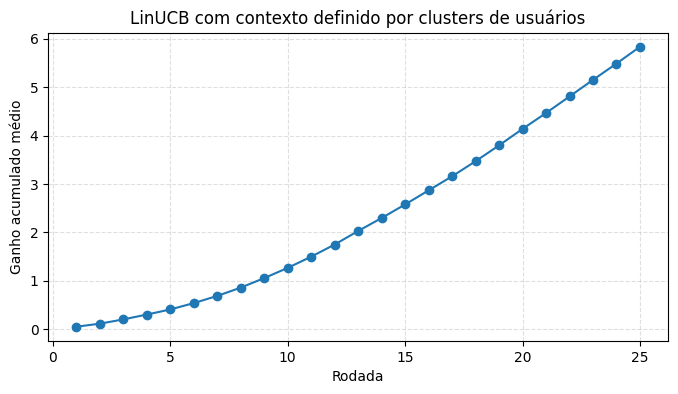

,round,avg_reward,avg_cumulative_gain
0,1,0.045714,0.045714
1,2,0.062857,0.108571
2,3,0.088571,0.197143
3,4,0.100000,0.297143
4,5,0.105714,0.402857
5,6,0.131429,0.534286
6,7,0.148571,0.682857
7,8,0.171429,0.854286
8,9,0.197143,1.051429
9,10,0.211429,1.262857


In [35]:
context_dim = user_features.shape[1] + movie_feature_matrix.shape[1]
available_movies = np.arange(num_movies)

def build_context_matrix(user_idx: int) -> np.ndarray:
    user_vec = user_features.loc[user_idx].to_numpy(dtype=np.float32)
    repeated_user = np.repeat(user_vec[np.newaxis, :], num_movies, axis=0)
    return np.hstack([repeated_user, movie_feature_matrix])

# Dicionário com feedback binário dos usuários no conjunto de teste
user_feedback_lookup = {
    user_idx: dict(zip(group['movie_idx'], group['positive_feedback'].astype(int)))
    for user_idx, group in test_ratings.groupby('user_idx')
}
evaluated_users = sorted(user_feedback_lookup.keys())

LINUCB_ALPHA = 1.0
N_ROUNDS_PER_USER = 25
MAX_USERS = 350  # Limita o número de usuários para reduzir o tempo total
num_eval_users = min(len(evaluated_users), MAX_USERS)
linucb_cluster = LinUCBRecommender(
    n_features=context_dim,
    n_arms=num_movies,
    alpha=LINUCB_ALPHA
)

cumulative_rewards = np.zeros(N_ROUNDS_PER_USER)
for user_idx in tqdm(evaluated_users[:MAX_USERS], desc="LinUCB (clusters)", unit="usuário"):
    contexts = build_context_matrix(user_idx)
    for round_idx in range(N_ROUNDS_PER_USER):
        chosen_arm = linucb_cluster.select_arm(contexts)
        movie_global_idx = popular_movie_indices[chosen_arm]
        reward = user_feedback_lookup[user_idx].get(movie_global_idx, 0)
        linucb_cluster.update(chosen_arm, contexts, reward)
        cumulative_rewards[round_idx] += reward

average_reward_per_round = cumulative_rewards / num_eval_users
average_cumulative_gain = np.cumsum(average_reward_per_round)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(np.arange(1, N_ROUNDS_PER_USER + 1), average_cumulative_gain, marker='o')
ax.set_xlabel('Rodada')
ax.set_ylabel('Ganho acumulado médio')
ax.set_title('LinUCB com contexto definido por clusters de usuários')
ax.grid(True, linestyle='--', alpha=0.4)
plt.show()

pd.DataFrame({
    'round': np.arange(1, N_ROUNDS_PER_USER + 1),
    'avg_reward': average_reward_per_round,
    'avg_cumulative_gain': average_cumulative_gain
})